In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
df = pd.read_parquet('data/df_v2.pqt')

In [3]:
df['V3_scope'].value_counts()

UNCHANGED    65205
CHANGED      13059
Name: V3_scope, dtype: int64

### The outcome is binary, slightly unbalanced

In [4]:
df.select_dtypes(['object']).columns

Index(['cve_id', 'V2_severity', 'V2_userInteractionRequired', 'V2_version',
       'V2_vectorString', 'V2_accessVector', 'V2_accessComplexity',
       'V2_authentication', 'V2_confidentialityImpact', 'V2_integrityImpact',
       'V2_availabilityImpact', 'V2_acInsufInfo', 'V3_version',
       'V3_vectorString', 'V3_attackVector', 'V3_attackComplexity',
       'V3_privilegesRequired', 'V3_userInteraction', 'V3_scope',
       'V3_confidentialityImpact', 'V3_integrityImpact',
       'V3_availabilityImpact', 'V3_baseSeverity'],
      dtype='object')

### This means that in order to predict, we cannot use the V3 columns, since they will not be defined for the predictions

In [5]:
# only get V2 columns, plus id and target
# also remove V2_vectorString, since it is an aggregate of other values and has a high cardinality
valid_cols = ['cve_id', 'V3_scope'] + [col for col in df.columns if col.startswith('V2_') and col != 'V2_vectorString']
df = df[valid_cols]

In [6]:
string_columns = ['V2_severity', 'V2_userInteractionRequired', 'V2_version',
       'V2_accessVector', 'V2_accessComplexity', # 'V2_vectorString', 
       'V2_authentication', 'V2_confidentialityImpact', 'V2_integrityImpact',
       'V2_availabilityImpact', 'V2_acInsufInfo', 'V3_scope']

rows_to_drop = df['V3_scope'].isna()
# We convert strings to categorical and then numeric in case we want to use numerical methods
cats = df.loc[:, string_columns].astype('category')
df.loc[:, string_columns] = cats.apply(lambda col: col.cat.codes)

In [7]:
# We only process those that are valid for training
print(df.shape)
df_to_predict = df[rows_to_drop]
df = df[~rows_to_drop]
print(df.shape)

(151637, 18)
(78264, 18)


In [8]:
df.dtypes

cve_id                         object
V3_scope                         int8
V2_severity                      int8
V2_exploitabilityScore        float64
V2_impactScore                float64
V2_obtainAllPrivilege            bool
V2_obtainUserPrivilege           bool
V2_obtainOtherPrivilege          bool
V2_userInteractionRequired       int8
V2_version                       int8
V2_accessVector                  int8
V2_accessComplexity              int8
V2_authentication                int8
V2_confidentialityImpact         int8
V2_integrityImpact               int8
V2_availabilityImpact            int8
V2_baseScore                  float64
V2_acInsufInfo                   int8
dtype: object

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [10]:
valid_for_training = df[~df['V3_scope'].isna()]

In [11]:
X = valid_for_training.drop(columns=['cve_id', 'V3_scope'])
y = valid_for_training['V3_scope']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
X_train.shape

(54784, 16)

In [14]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced')

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1)

In [16]:
y_pred = rf.predict(X_test)

In [17]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 3153,   738],
       [  959, 18630]])

In [18]:
balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

0.8806877437745044

In [19]:
# To check overfitting
y_pred_train = rf.predict(X_train)
balanced_accuracy_score(y_true=y_train, y_pred=y_pred_train)

0.8931126742522602

## We repeat the experiment to be certain that the sampling did not play a part

In [20]:
n_reps = 30

balanced_accuracies = []
for rep in tqdm(range(n_reps)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    balanced_accuracies.append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

  0%|          | 0/30 [00:00<?, ?it/s]

(array([2., 2., 6., 6., 9., 2., 1., 1., 0., 1.]),
 array([0.88007252, 0.88021017, 0.88034783, 0.88048549, 0.88062314,
        0.8807608 , 0.88089846, 0.88103611, 0.88117377, 0.88131143,
        0.88144908]),
 <BarContainer object of 10 artists>)

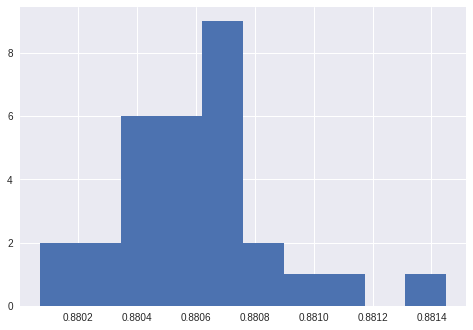

In [21]:
plt.style.use('seaborn')
plt.hist(balanced_accuracies)

In [22]:
np.mean(balanced_accuracies), np.min(balanced_accuracies)

(0.8806029865067846, 0.8800725180012873)

# With a basic model, we get a mean balanced accuracy of 88%
A fair assumption is that it will perform similarly for the data without labels, since it does not seem to overfit
The feature relevances are:

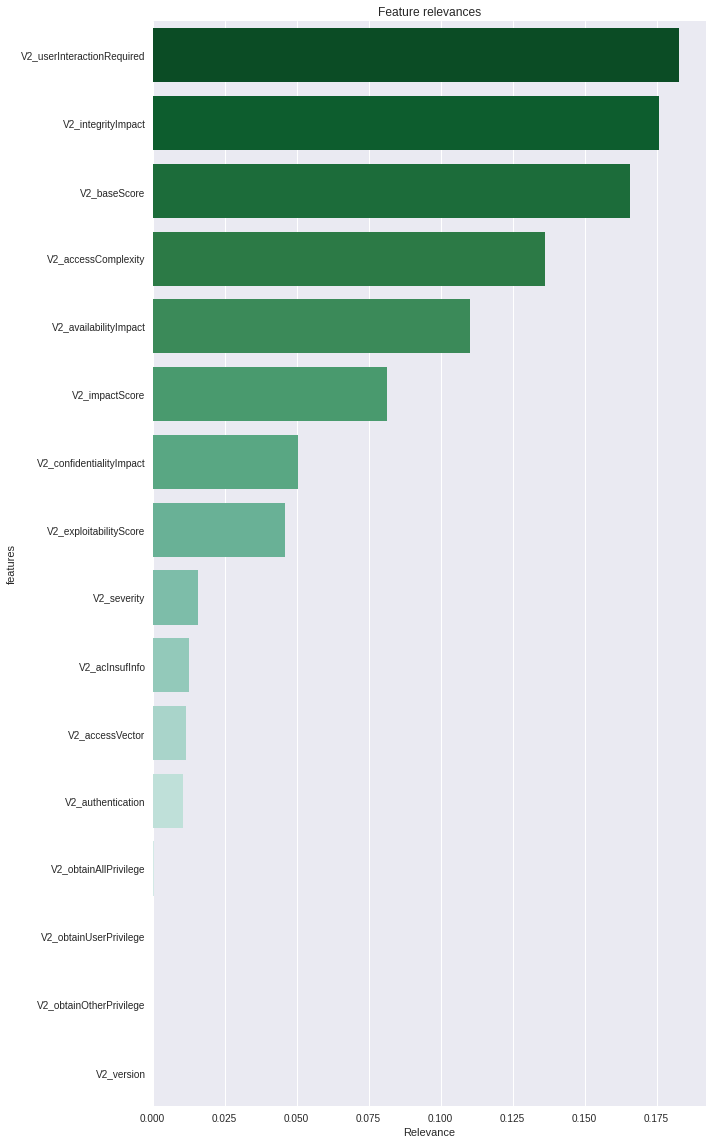

In [23]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(10, 16))

data = pd.DataFrame({'features': X_train.columns, 'relevance': rf.feature_importances_})
data.sort_values('relevance', inplace=True, ascending=False)

sns.barplot(x="relevance", y="features", data=data,
            palette=sns.color_palette("BuGn_r", n_colors=len(data)))

plt.title('Feature relevances')
plt.xlabel('Relevance')
plt.tight_layout()

In [24]:
X.nunique()

V2_severity                    3
V2_exploitabilityScore        20
V2_impactScore                 9
V2_obtainAllPrivilege          2
V2_obtainUserPrivilege         2
V2_obtainOtherPrivilege        2
V2_userInteractionRequired     3
V2_version                     1
V2_accessVector                3
V2_accessComplexity            3
V2_authentication              3
V2_confidentialityImpact       3
V2_integrityImpact             3
V2_availabilityImpact          3
V2_baseScore                  68
V2_acInsufInfo                 3
dtype: int64

In [25]:
X.describe()

,V2_severity,V2_exploitabilityScore,V2_impactScore,V2_userInteractionRequired,V2_version,V2_accessVector,V2_accessComplexity,V2_authentication,V2_confidentialityImpact,V2_integrityImpact,V2_availabilityImpact,V2_baseScore,V2_acInsufInfo
count,78264.000000,78264.000000,78264.000000,78264.000000,78264.0,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000
mean,1.344168,7.958267,5.312388,0.342073,0.0,1.799934,1.384979,1.191506,1.332848,1.347491,1.208640,5.730632,-0.305466
std,0.873329,2.115653,2.588732,0.497775,0.0,0.451320,0.527469,0.393943,0.745629,0.743109,0.747604,1.943068,0.560558
min,0.000000,1.200000,2.900000,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
25%,0.000000,6.800000,2.900000,0.000000,0.0,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.300000,-1.000000
50%,2.000000,8.600000,4.900000,0.000000,0.0,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,5.000000,0.000000
75%,2.000000,10.000000,6.400000,1.000000,0.0,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,7.200000,0.000000
max,2.000000,10.000000,10.000000,1.000000,0.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000,1.000000


In [26]:
# The predictions for the missing data are:
X_to_predict = df_to_predict.drop(columns=['cve_id', 'V3_scope'])
y_expected = rf.predict(X_to_predict)

In [27]:
# Store the results, converting them to the original categories
results = df_to_predict[['cve_id']].copy()

results['V3_scope'] = cats['V3_scope'].cat.categories[y_expected]

# We upload it as a csv to be able to display the results easily with other applications
results.to_csv('results/scope_results_rf.csv', index=False)